# $R_x(\pi/2)$ gate

In [1]:
using Sisyphus
using QuantumOptics
using Flux, DiffEqFlux
using Plots
using Random
using ProgressMeter

ProgressMeter.ijulia_behavior(:clear);

A transmon is a Josephson junction (non linear inductor) shunted with a capacitor. The quantum mechanical Hamiltonian of such a system often referred to as a Cooper pair box is given,
    
$$ H = 4 E_c (n - n_g)^2 - E_J \cos\varphi,$$
where $n$ and $\varphi$ are the Cooper pair number and phase conjugate variables, $n_g$ is charge bias, $E_J$ and $E_c$ denote the Josephson and charging energies respectively.  The non linear nature of the Josephson junction makes the transmon an anharmonic oscillator, effectively isolating the first two levels from the remaining levels to realize a qubit (i.e. $\omega_{01}\neq \omega_{12}$). The evolution of transmons is modelled with a generalized Duffing Oscillator resulting from the expansion of Cooper pair box Hamiltonian,
    
$$H_{DO_K} = \omega_0 \left(a^{\dagger}a + \frac{1}{2}\right) +\frac{\omega_0^2}{8\eta} \sum_{k=2}^{K} \left(\frac{4\eta}{\omega_0}\right)^{k}\frac{(-1)^k (a^{\dagger} + a)^{2k}}{(2k)!} +  i f(t)\cos[\omega'(t)t + \phi(t)](a - a^{\dagger}), $$
where $\omega_0$ is the qubit frequency, $\eta$ is the anharmonicity (note that $\omega_{01} \approx \omega_0 + \eta $), $f(t)$ is the slow varying envelope of the RF drive. The microwave frequency $\omega'$ is typically in the $GHz$ range and therefore it is generated by mixing a low frequency signal of few $MHz$ with a local oscillator $\omega' = \omega_{LO} + \omega_{IF}$. The $I$ and $Q$ quadratures of slow varying envelope,
    
$$[I(t), Q(t)] = [f(t)\cos(\phi(t)), f(t) \sin(\phi(t))].$$
    
Jones *et al.*  argue that for typical transmon parameters, sextic terms ($K=3$) are enough to match the spectrum of the Cooper pair box Hamiltonian ($K=\infty$). In general, the minimum number of levels and expansion order needed to accurately model the dynamics depends on the anharmonicity, strength of the drive etc. these parameters have to be chosen based on the desired accuracy, for e.g. by monitoring the occupation probabilities of lower energy levels.

In this notebook we show how to design smooth 4 ns pulses to do a $R_x(\pi/2)$ gate, by including the first 12
levels of a transmon, in a few minutes! (simulations are done in the lab frame)

In [2]:
ω₀ = 2π*5.0
η = -2π*300*1e-3
ωlo = ω₀

31.41592653589793

In [3]:
n_levels = 12
bs = FockBasis(n_levels-1)
a = destroy(bs)
ad = create(bs)
id = identityoperator(bs, bs);

In [4]:
H0 = ω₀*(ad*a + 0.5*id) + (η/12.0)*(a + ad)^4 - η^2 * (a + ad)^6/ω₀/90.0
H1 = 1.0im*(a - ad);

we parametrize the waveforms using a neural network with one input ($t$) and two outputs ($I(t)$ and $Q(t)$), we then train the neural network to produce DRAG pulse like waveforms

In [5]:
n_neurons = 8
Random.seed!(1)
ann = FastChain(FastDense(1, n_neurons, tanh), 
                FastDense(n_neurons, n_neurons, tanh),
                FastDense(n_neurons, 2))
t0, t1 = 0.0, 4.0

I_guess(t) = @. -2π*exp(-(t-0.5*t1)^2/(0.2*t1)^2)*2.0*(t-0.5*t1) /(0.2*t1)^2
Q_guess(t) = @. -2π*exp(-(t-0.5*t1)^2/(0.2*t1)^2)

tsf32 = Float32(t0):0.001f0:Float32(t1)
Is = Vector{Float32}(I_guess(tsf32))
Qs = Vector{Float32}(Q_guess(tsf32))

ts = Vector{Float64}(tsf32)
function loss(p)
    c = 0.0f0
    for (i,t) in enumerate(tsf32)
        x = ann([t], p)
        c += (x[1] - Is[i])^2
        c += (x[2] - Qs[i])^2
    end
    c
end
res = DiffEqFlux.sciml_train(loss, initial_params(ann), Adam(0.1f0), maxiters = 500)
θ = Vector{Float64}(res.u);

time dependant drive after mixing with local oscillator

In [6]:
coeffs(params, t) = let b = ann([t], params)
                        [b[1]*cos(ωlo*t) + b[2]*sin(ωlo*t)]
                    end

coeffs (generic function with 1 method)

we specify the objective to optimize, first argument includes the infidelity and the second one takes the constraints on the waveforms, here we simply pin $I$ and $Q$ to be zero at $t_0$ and $t_1$

In [7]:
bcs(params) = 0.01*sum(ann([t0], params).^2 + ann([t1], params).^2)
                 
cost = CostFunction((x,y)-> 1.0-real(x'*y), bcs)

CostFunction(var"#1#2"(), bcs)

Unitary transformation denoting $R_x(\pi/2)$ gate

In [8]:
trans = UnitaryTransform([fockstate(bs, 0), fockstate(bs, 1)], 
                         [[1.0 -1.0im];[-1.0im 1.0]]/√2);

Hamiltonian of the problem

In [9]:
H = Hamiltonian(H0, [H1], coeffs);

QOCProblem definition

In [10]:
prob = QOCProblem(H, trans, (t0, t1), cost);

we use the DRAG like pulses as an initial guess and solve the problem

In [11]:
@time sol = solve(prob, θ, Adam(0.02); maxiter=100);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:34
  distance:     0.00487591354733552
  constraints:  7.803988353750598e-5


171.865075 seconds (664.66 M allocations: 62.231 GiB, 23.89% gc time, 20.43% compilation time)


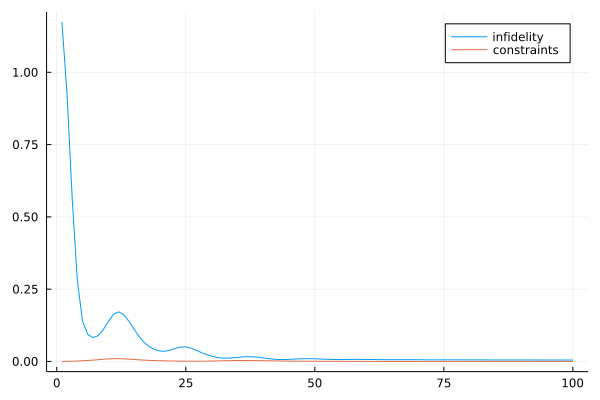

In [12]:
plot(sol.distance_trace, label="infidelity")
plot!(sol.constraints_trace, label="constraints")

In [13]:
I_wf(t) = ann([t], sol.params)[1]/2π
Q_wf(t) = ann([t], sol.params)[2]/2π

Q_wf (generic function with 1 method)

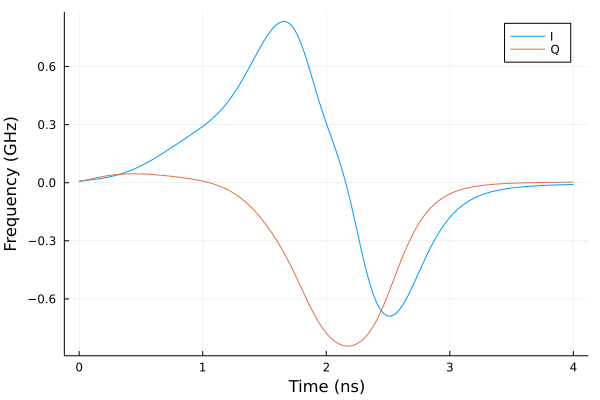

In [14]:
plot(ts, I_wf.(ts), label="I")
plot!(ts, Q_wf.(ts), label="Q")
xlabel!("Time (ns)")
ylabel!("Frequency (GHz)")

In [15]:
tout, psit = schroedinger_dynamic(ts, fockstate(bs, 0), H, sol.params);

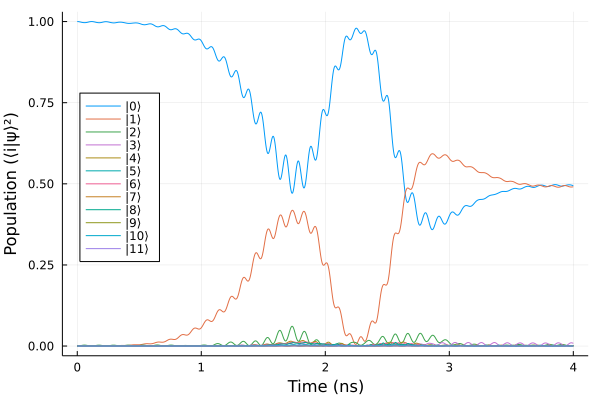

In [16]:
f = plot()
for i in 0:11
    plot!(f, ts, real(expect(dm(fockstate(bs, i)), psit)),
          label="|"*string(i)*"⟩", legend=:left)
end
xlabel!(f, "Time (ns)")
ylabel!(f, "Population (⟨i|ψ⟩²)")
f